## 1. 필요한 패키지 불러오기

In [21]:
import pandas as pd
import numpy as np
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 2. 사용할 데이터 불러오기

In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 64
EPOCHS = 20

TRAIN_PATH = './data/train/*/*' 
VAL_PATH = './data/val/*/*'
TEST_PATH = './data/test/*/*'

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(200)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [42]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

## 3. 데이터 전처리

In [43]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


가우시안 커널을 적용한 데이터 증강을 시도하였지만 큰 효과를 보지 못하였습니다.

In [44]:
# def _gaussian_kernel(kernel_size, sigma, n_channels, dtype):
#     x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
#     g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
#     g_norm2d = tf.pow(tf.reduce_sum(g), 2)
#     g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
#     g_kernel = tf.expand_dims(g_kernel, axis=-1)
#     return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)
# # 가우시안 흐림효과 적용 함수
# def apply_blur(img):
#     blur = _gaussian_kernel(3, 2, 3, img.dtype)
#     img = tf.nn.depthwise_conv2d(img[None], blur, [1,1,1,1], 'SAME')
#     return img[0]



def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [46]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [47]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [48]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    # tf.dataset에서 기존 이미지셋과 필터 이미지셋을 concat하여 하나의 훈련데이터셋으로 만들었지만 
    # 가우시안 커널을 적용한 데이터셋의 효과가 미미하여 주석처리하였습니다.
    #aas = ds.map(lambda x, y, : (apply_blur(x), y))
    #ds = ds.concatenate(aas)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [49]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

print(f"Normal images count in training set: {COUNT_NORMAL} : {round(COUNT_NORMAL / (COUNT_NORMAL + COUNT_PNEUMONIA), 2)*100}%")
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA} : {round(COUNT_PNEUMONIA / (COUNT_NORMAL + COUNT_PNEUMONIA), 2)*100}%")

Normal images count in training set: 1087 : 26.0%
Pneumonia images count in training set: 3098 : 74.0%


## 4. 데이터 시각화

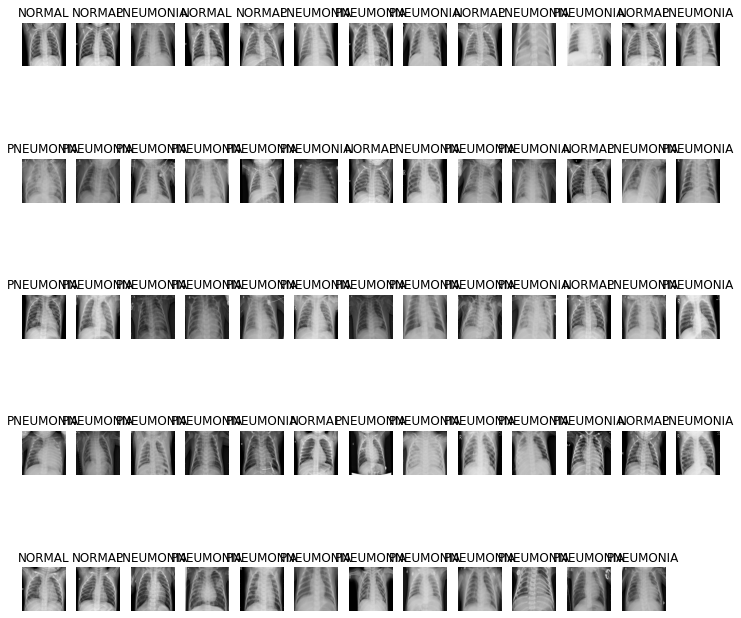

In [64]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

plt.tight_layout()
plt.show()

## 5. 페렴 이진분류 모델 설계

In [50]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [51]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [52]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [54]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.93
Weight for PNEUMONIA: 0.68


In [55]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
es = tf.keras.callbacks.EarlyStopping(monitor='val_precision', verbose=1, patience=4)
mc = tf.keras.callbacks.ModelCheckpoint('./models/best_model.h5', monitor='val_precision', save_best_only=True)

In [56]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
        callbacks = [mc]
    )

Epoch 1/20
65/65 [==============================] - 64s 837ms/step - loss: 0.5353 - accuracy: 0.7261 - precision: 0.9133 - recall: 0.7007 - val_loss: 0.5747 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 2/20
65/65 [==============================] - 54s 834ms/step - loss: 0.1960 - accuracy: 0.9254 - precision: 0.9807 - recall: 0.9178 - val_loss: 0.6665 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/20
65/65 [==============================] - 55s 847ms/step - loss: 0.1470 - accuracy: 0.9471 - precision: 0.9873 - recall: 0.9418 - val_loss: 0.8008 - val_accuracy: 0.7490 - val_precision: 0.7490 - val_recall: 1.0000
Epoch 4/20
65/65 [==============================] - 56s 867ms/step - loss: 0.1233 - accuracy: 0.9542 - precision: 0.9805 - recall: 0.9564 - val_loss: 0.9170 - val_accuracy: 0.7520 - val_precision: 0.7520 - val_recall: 1.0000
Epoch 5/20
65/65 [==============================] - 62s 960ms/step - loss: 0.0938 - accuracy: 0.9636

## 6. 모델 평가

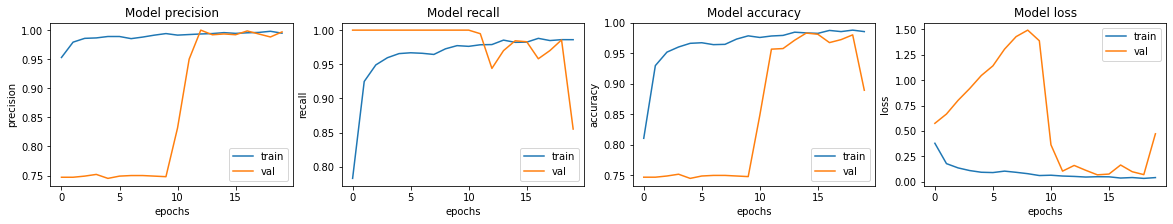

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [63]:
model.save("./models/best_accuracy88.h5")

best_model = tf.keras.models.load_model("./models/best_accuracy88.h5")

loss, accuracy, precision, recall = best_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 6s 458ms/step - loss: 0.4308 - accuracy: 0.8846 - precision: 0.8897 - recall: 0.9308
Loss: 0.4307969808578491,
Accuracy: 0.8846153616905212,
Precision: 0.8897058963775635,
Recall: 0.9307692050933838
